## Comparison of `TransferRates` with SaltProc

I compared the new `TransferRates` feature in OpenMC for continuous fuel reprocessing and transfering with the batchwise approach of SaltProc. I ran two cases:

1. Only removals, with the removal constants matching the cycle times in Table 6.B in ORNL 4548
2. Same as 1, but with a feed rate corresponding to the feed rate as calculated from SaltProc results.

In [1]:
import saltproc
import matplotlib.pyplot as plt
import numpy as np
from openmc.deplete import Results
import openmc

In [2]:
ref_res = saltproc.Results('../2022-yardas-ms/model/openmc/saltproc_runtime/saltproc_results.h5')
dep_no_feed = Results('no_feeding/depletion_results.h5')
dep_with_feed = Results('with_feeding/depletion_results.h5')

In [4]:
time = dep_no_feed.get_times()
ref_time = ref_res.time_total
ref_time_idx = np.where(ref_time == time[-1])[0][-1] + 1
ref_time = ref_time[:ref_time_idx]

keff_ref = [k.n for k in ref_res.keff[:ref_time_idx]]
keff_no_feed = dep_no_feed.get_keff()[1][:,0]
keff_with_feed = dep_with_feed.get_keff()[1][:,0]

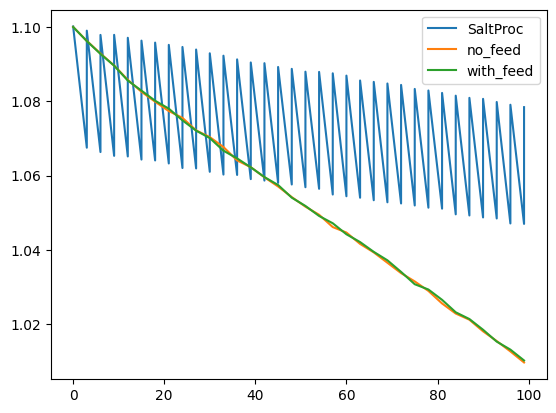

In [8]:
plt.plot(ref_time, keff_ref, label='SaltProc')
plt.plot(time, keff_no_feed, label='no_feed')
plt.plot(time, keff_with_feed, label='with_feed')
plt.legend()

Notice that both cases have the same trend for $k_\text{eff}$, but neither of them match SaltProc partiuclarly well. One possible explanation for this can be derived from investigating Th232 and U233 behavior in both cases.

In [9]:
def get_mass_density(nuc, res):
    time, atoms = res.get_atoms('1', nuc)
    mass = atoms * openmc.data.atomic_mass(nuc) \
                        / openmc.data.AVOGADRO
    return mass


ss_idx = []
s_idx = 0
for t in ref_time:
    s_idx += 1
    ss_idx += [s_idx]

u233_ref = ref_res.get_nuclide_mass('fuel', 'U233', ss_idx)
th232_ref = ref_res.get_nuclide_mass('fuel', 'Th232', ss_idx)

th232_no_feed = get_mass_density('Th232', dep_no_feed)
u233_no_feed = get_mass_density('U233', dep_no_feed)

th232_with_feed = get_mass_density('Th232', dep_with_feed)
u233_with_feed = get_mass_density('U233', dep_with_feed)

Text(0, 0.5, 'U233 mass [g]')

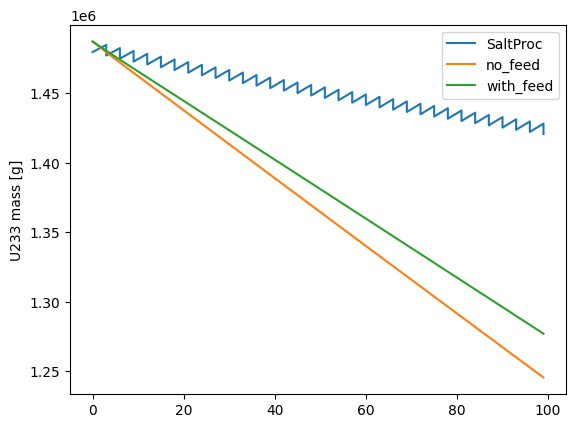

In [17]:
plt.plot(ref_time, u233_ref, label='SaltProc')
plt.plot(time, u233_no_feed, label='no_feed')
plt.plot(time, u233_with_feed, label='with_feed')
plt.legend()
plt.ylabel('U233 mass [g]')

We see a slighly slower delcine in the mass of U233 in the case with feeding that the case without, but both are off of the trend for SaltProc.

Text(0, 0.5, 'Th232 mass [g]')

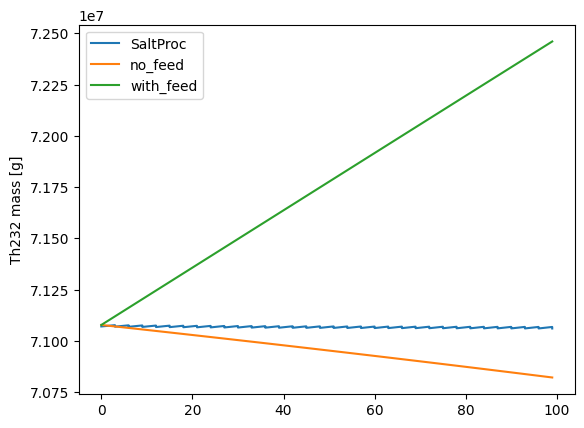

In [18]:
plt.plot(ref_time, th232_ref, label='SaltProc')
plt.plot(time, th232_no_feed, label='no_feed')
plt.plot(time, th232_with_feed, label='with_feed')
plt.legend()
plt.ylabel('Th232 mass [g]')

Here we see a much more drastic difference between the case with feeding and the case without feeding. In SaltProc, the Th232 remains relatively constant, but in the case with feeding, the mass increases over time, whereas in the case without feeding it decreases.

It may very well be possible to find constants that reproduce SaltProcs behavior at a more steady state, but SaltProc conserves the initial mass of the burnable material by adjusting how much feed material gets added to the mass of removed material, whereas `TransferRates` does not guarantee this to be the case, as it uses user defined removal/feed rates to remove/add nuclides to a material.

## MSBR Reference Design Analysis

The MSBR model contained in this repository is based off of work I did for my M.S. thesis at the University of Illinois Urbana Champaign. See that document for details on the design.

### MSBR Control rods

The MSBR reference design calls for "two or more" graphite control rods. My simulations with OpenMC using the ENDF B/VII.1 cross section library show that the rods as specified in the reference design do not provide significant reactivitiy control.

| CR | $k_\text{eff}$ |
| --- | --- |
| control rods withdrawn | 1.08283 +/- 0.00034 |
| control rods inserted | 1.08491 +/- 0.00033 |

In ORNL-4548 Section 6.1.4, the authors report that the difference in $k_\text{eff}$ between the case with control rods fully inserted and the case with control rods fully removed is $\delta k = k_\text{in} - k_\text{out} = +0.0033$. Our OpenMC calculation gives us a value very close to this:

In [3]:
keff_0 = 1.08283
keff_1 = 1.08491

p0 = (keff_0 - 1) / keff_0
p1 = (keff_1 - 1) / keff_1

keff_1 - keff_0

0.002080000000000082

with $\delta k = 1.08491 - 1.08283 = +0.002$. It is important to note that due to the computational limitations of the time, the geometry the authors in ORNL-4548 performed their monte carlo simulation on consisted of the four 6 in x 6 in elements in the center of the reactor and the core elements directly adjacent to them.

In the MSBR reference design report, the authors state that this control rod worth is adequate to control the reactor. However, we disagree and think that having all reactor control based at the center of the core does not give an operator sufficient control of the reactor. We can see this if we plot the flux and absorptions over the MSBR geometry:

In [1]:
# Load the statepoint file
from IPython.display import Image
import openmc
import matplotlib.pyplot as plt
sp = openmc.StatePoint('neutron_mesh/statepoint.200.h5')

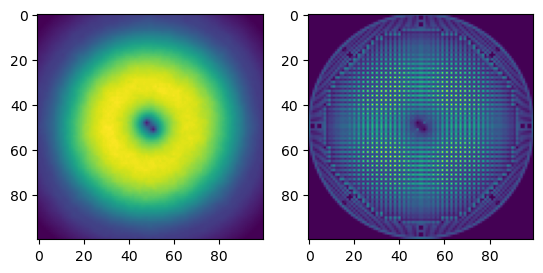

In [2]:
tally = sp.get_tally(scores=['flux'])
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])

flux.std_dev.shape = (100, 100)
flux.mean.shape = (100, 100)
fission.std_dev.shape = (100, 100)
fission.mean.shape = (100, 100)

fig = plt.subplot(121)
fig.figsize = (8,6)
fig.imshow(flux.mean)
fig2 = plt.subplot(122)
fig2.imshow(fission.mean)

In these images, two aborbing rods have been fully inserted into the core along with two grapite rods.

In the MSBR Reference report, the authors state that "long term reactivitiy adjustments will be accomplished in the MSBR by varying the fuel concentration." (ORNL 4541, p118). Due to limited computational resources, I have been unable to demonstrate that this is indeed possible on the full-core model of the MSBR. I created an approximate model of an MSBR pincell, and performed a short test simulation to see if we could maintain $k_\text{eff} \approx 1$ by only controlling how much material we add into the fuel salt.

Using the `Batchwise` feature that is not yet released in OpenMC, I found that adding between 5 and 20 grams of 45% U233 and 55% Th232 after each depletion step allowed us to maintain criticallity (once, of coure, the excess criticality from inital loading had dissipated). For each of the 1436 pin cells, this means adding between roughly 7 and 29 kg of salt every 3 days to maintain criticality. Of course, such a complicated geometry cannot be so easily simplified, so the exact numbers are most certainly different, however this demonstrates that the basic reasoning is sound.